# CLG Step 3: Network Construction & Analysis

This notebook processes the calibrated single-neuron traces to construct functional connectivity networks and analyze their topology.

**Workflow:**
1.  **Load Data**: Import the calibrated traces from Step 2.
2.  **Preprocessing**:
    *   **Denoising (PCA)**: Use Principal Component Analysis to reconstruct traces and reduce noise.
    *   **dF/F Calculation**: Compute relative fluorescence changes.
3.  **Network Construction**:
    *   Compute Pairwise Pearson Correlation Matrix.
    *   Define Edges based on a high correlation threshold (e.g., > 0.95).
4.  **Network Analysis**:
    *   Compute topological metrics: **Degree**, **Eigenvector Centrality**, **Clustering Coefficient**.
    *   Compare distributions.
5.  **Visualization**: Plot metric distributions.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import networkx as nx
from joblib import Parallel, delayed

try:
    import allensdk.brain_observatory.dff as dff
    HAS_ALLEN = True
except ImportError:
    print("AllenSDK not found. A simple dF/F fallback will be used.")
    HAS_ALLEN = False

INPUT_FILE = r'/home/jjzhao/CLG-Volumetric-Imaging-Analysis-Framework/main/extraction/fish4_example/spon/extraction_results/CellTrace_after_calibration.npz'
PCA_VARIANCE_THRESHOLD = 0.95
CORRELATION_THRESHOLD = 0.95
SAMPLING_RATE = 1.0 

print(f"Loading data from: {INPUT_FILE}")

AllenSDK not found. A simple dF/F fallback will be used.
Loading data from: /home/jjzhao/CLG-Volumetric-Imaging-Analysis-Framework/main/extraction/fish4_example/spon/extraction_results/CellTrace_after_calibration.npz


## 1. Load Calibrated Data

In [4]:
data = np.load(INPUT_FILE)
traces = data['trace']
positions = data['pos']
ids = data['nucIndex']

print(f"Loaded {traces.shape[0]} neurons with {traces.shape[1]} timepoints.")

valid_mask = np.any(traces != 0, axis=1)
traces = traces[valid_mask]
positions = positions[valid_mask]
ids = ids[valid_mask]

print(f"After cleaning zeros: {traces.shape[0]} neurons remain.")

Loaded 2226 neurons with 599 timepoints.
After cleaning zeros: 2226 neurons remain.


## 2. Preprocessing: dF/F & PCA Denoising

In [5]:
def compute_dff_simple(traces, window=600):
    """Fallback sliding window median dF/F"""

    return (traces - np.mean(traces, axis=1, keepdims=True)) / (np.mean(traces, axis=1, keepdims=True) + 1e-6)

def compute_dff_allen_wrapper(traces, fs):
    if not HAS_ALLEN:
        return compute_dff_simple(traces)
    

    median_kernel_long = int(600 * fs // 2 * 2 + 1)
    median_kernel_short = int((10/3) * fs // 2 * 2 + 1)
    

    dff_traces = dff.compute_dff_windowed_median(
        traces, 
        median_kernel_long=median_kernel_long,
        median_kernel_short=median_kernel_short
    )
    return dff_traces

print("Computing dF/F...")

traces_dff = compute_dff_allen_wrapper(traces, SAMPLING_RATE)
print("dF/F calculation complete.")

def pca_reconstruction(data, variance_threshold=0.95):
    print("Running PCA Denoising...")
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.T).T 
 
    
    pca = PCA(n_components=variance_threshold, svd_solver='full')
    
    data_t = data.T
    data_transformed = pca.fit_transform(data_t)
    
    print(f"Selected {pca.n_components_} components explaining {np.sum(pca.explained_variance_ratio_)*100:.2f}% variance.")
    
    data_reconstructed_t = pca.inverse_transform(data_transformed)
    return data_reconstructed_t.T 

traces_denoised = pca_reconstruction(traces_dff, PCA_VARIANCE_THRESHOLD)

Computing dF/F...
dF/F calculation complete.
Running PCA Denoising...
Selected 22 components explaining 95.02% variance.


## 3. Network Construction
Compute the correlation matrix and define the graph.

In [6]:
print("Computing Correlation Matrix...")

dist_matrix = pdist(traces_denoised, metric='correlation')
corr_matrix = 1 - squareform(dist_matrix)

np.fill_diagonal(corr_matrix, 0)

print(f"Building Graph with Threshold > {CORRELATION_THRESHOLD}...")
adj_matrix = np.abs(corr_matrix) > CORRELATION_THRESHOLD

G = nx.from_numpy_array(adj_matrix)
print(f"Graph constructed: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

largest_cc = max(nx.connected_components(G), key=len)
G_sub = G.subgraph(largest_cc).copy()
print(f"Largest Connected Component: {G_sub.number_of_nodes()} nodes.")

Computing Correlation Matrix...
Building Graph with Threshold > 0.95...
Graph constructed: 2226 nodes, 132 edges.
Largest Connected Component: 28 nodes.


## 4. Network Metrics & Analysis
Calculate Degree, Eigenvector Centrality, etc.

In [7]:
print("Calculating Network Metrics...")

degrees = dict(G_sub.degree())
degree_values = list(degrees.values())

try:
    eigen_centrality = nx.eigenvector_centrality(G_sub, max_iter=1000)
    eigen_values = list(eigen_centrality.values())
except Exception as e:
    print(f"Eigenvector centrality failed to converge: {e}")
    eigen_values = []



print("Metrics calculation complete.")

Calculating Network Metrics...
Metrics calculation complete.


## 5. Visualization
Plot the Degree Distribution.

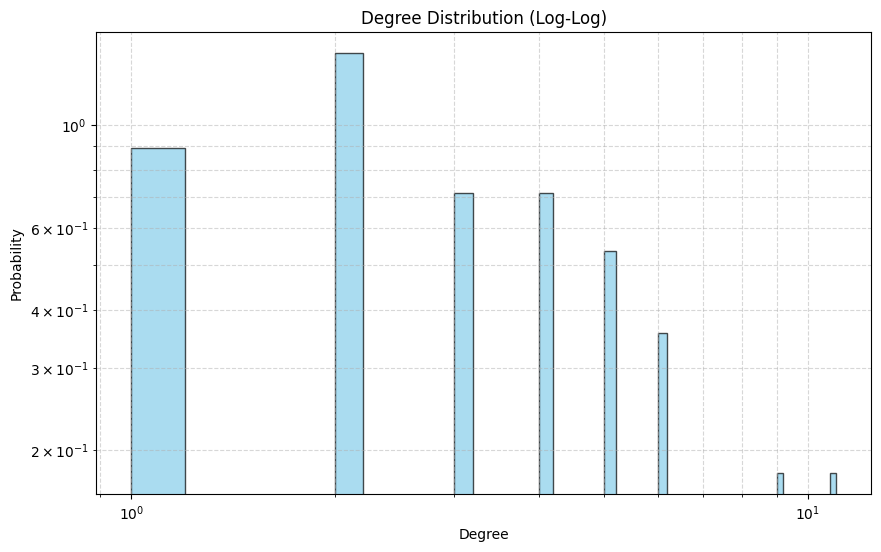

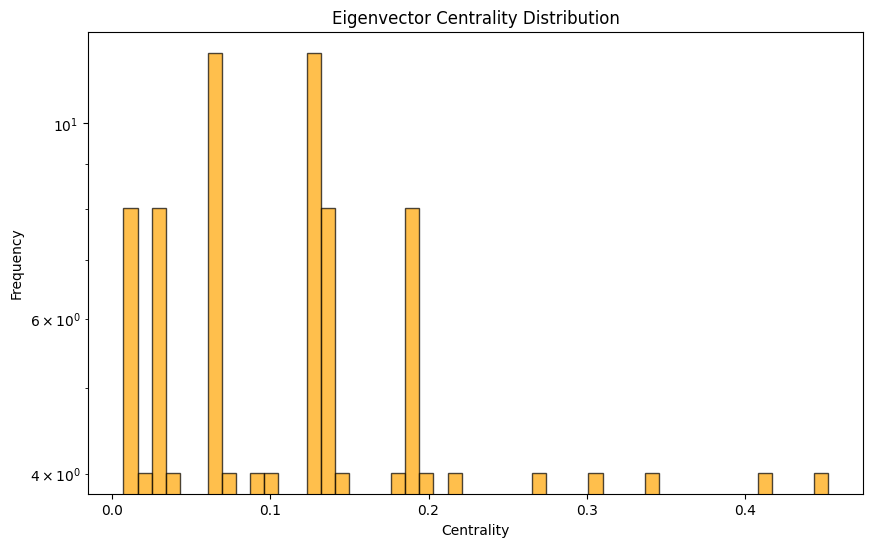

In [8]:
plt.figure(figsize=(10, 6))

plt.hist(degree_values, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.yscale('log')
plt.xscale('log')
plt.title("Degree Distribution (Log-Log)")
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

if eigen_values:
    plt.figure(figsize=(10, 6))
    plt.hist(eigen_values, bins=50, density=True, alpha=0.7, color='orange', edgecolor='black')
    plt.yscale('log')
    plt.title("Eigenvector Centrality Distribution")
    plt.xlabel("Centrality")
    plt.ylabel("Frequency")
    plt.show()